In [1]:
import random
import numpy as np
import pandas as pd
from scipy.stats.stats import spearmanr
import matplotlib.pyplot as plt
import pickle as pkl
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


# Read Data

In [2]:
data = pkl.load(open('data.pkl', 'rb'))

X_input_train = data['X_input_train']
X_output_train = data['X_output_train']
X_input_test = data['X_input_test']
X_output_test = data['X_output_test']

x1_trend_param = data['x1_trend_param']
x2_trend_param = data['x2_trend_param']
x_train_max = data['x_train_max']

# Model
![Image of Luong Attention](https://github.com/HuangWeiKulish/Forecasting/blob/master/seq2seq.png?raw=true)
![Image of Luong Attention](https://github.com/HuangWeiKulish/Forecasting/blob/master/Luong%20Attention.png?raw=true)

In [3]:
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot, Lambda
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

In [4]:
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
n_hidden = 100
print(input_train)
print(output_train)

Tensor("input_1:0", shape=(None, 200, 2), dtype=float32)
Tensor("input_2:0", shape=(None, 20, 2), dtype=float32)


#### What to Return using LSTM
- __*return_sequences=False, return_state=False*__: the last hidden state: state_h
- __*return_sequences=True, return_state=False*__: return stacked hidden states (num_timesteps * num_cells): one hidden state output for each input time step
- __*return_sequences=False, return_state=True*__: generate 3 arrays: state_h, state_h, state_c
- __*return_sequences=True, return_state=True*__: generate 3 arrays: stacked hidden states, last state_h, last state_c

In [5]:
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

Tensor("lstm_1/transpose_1:0", shape=(None, 200, 100), dtype=float32)
Tensor("lstm_1/while:4", shape=(None, 100), dtype=float32)
Tensor("lstm_1/while:5", shape=(None, 100), dtype=float32)


In [6]:
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h) 
print(encoder_last_h)

Tensor("batch_normalization_1/cond/Identity:0", shape=(None, 100), dtype=float32)


In [7]:
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
print(decoder_input)

Tensor("repeat_vector_1/Tile:0", shape=(None, 20, 100), dtype=float32)


In [8]:
decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
               return_state=False, return_sequences=True)(
    decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

Tensor("lstm_2/transpose_1:0", shape=(None, 20, 100), dtype=float32)


In [9]:
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
print(attention)

Tensor("activation_1/truediv:0", shape=(None, 20, 200), dtype=float32)


In [10]:
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context) ##
print(context)

Tensor("batch_normalization_2/cond/Identity:0", shape=(None, 20, 100), dtype=float32)


In [11]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

Tensor("concatenate_1/concat:0", shape=(None, 20, 200), dtype=float32)


In [12]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
print(out)

Tensor("time_distributed_1/Reshape_1:0", shape=(None, 20, 2), dtype=float32)


In [13]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 2)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 200, 100), ( 41200       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 100)          400         lstm_1[0][1]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 20, 100)      0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

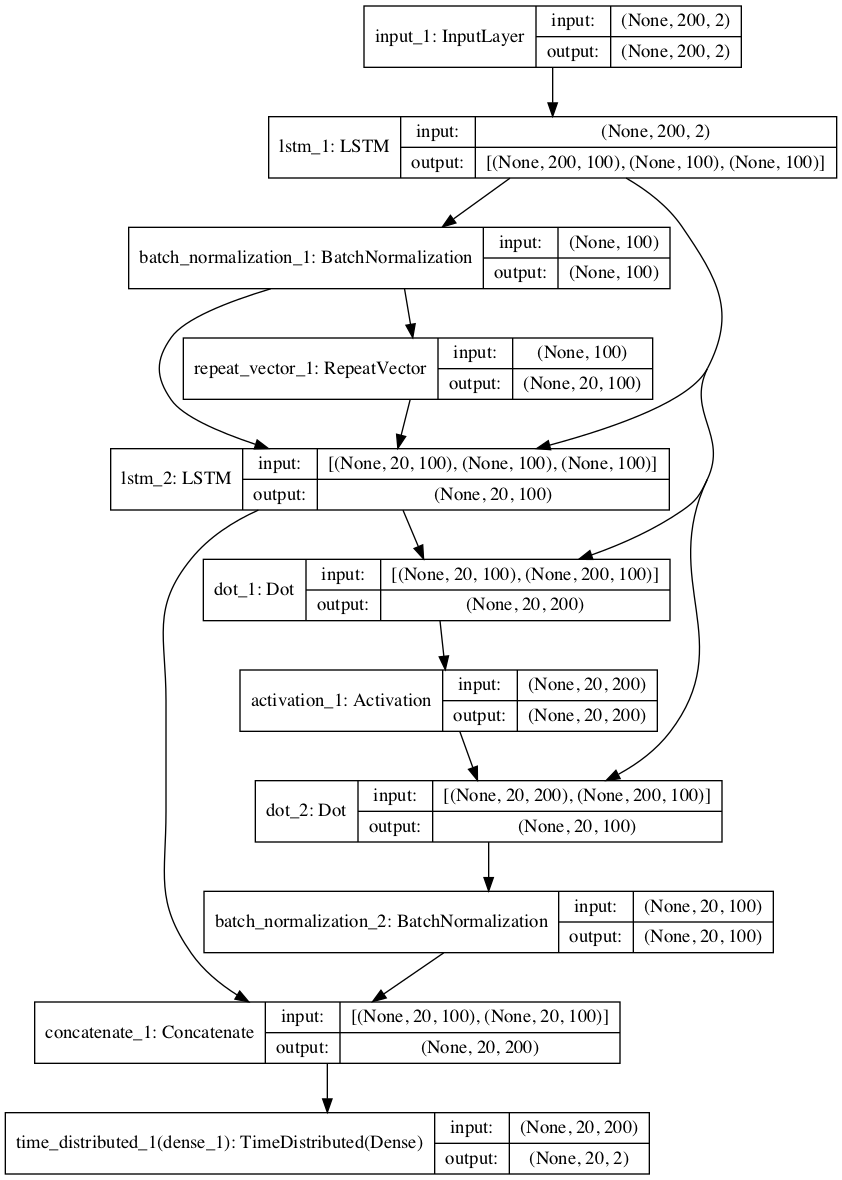

In [14]:
from keras.utils.vis_utils import plot_model
import pydot as pyd
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pyd

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']

model.save('model_forecasting_seq2seq_attention.h5')

Train on 480 samples, validate on 120 samples
Epoch 1/100
480/480 [==============================] - 4s 7ms/step - loss: 3.2318 - mae: 0.8804 - val_loss: 0.1708 - val_mae: 0.3128
Epoch 2/100
480/480 [==============================] - 2s 4ms/step - loss: 0.6585 - mae: 0.5430 - val_loss: 0.1466 - val_mae: 0.2726
Epoch 3/100
480/480 [==============================] - 2s 4ms/step - loss: 0.1702 - mae: 0.3142 - val_loss: 0.1782 - val_mae: 0.3286
Epoch 4/100
480/480 [==============================] - 2s 4ms/step - loss: 0.1499 - mae: 0.2911 - val_loss: 0.1475 - val_mae: 0.2862
Epoch 5/100
480/480 [==============================] - 2s 4ms/step - loss: 0.1405 - mae: 0.2770 - val_loss: 0.1420 - val_mae: 0.2817
Epoch 6/100
480/480 [==============================] - 2s 4ms/step - loss: 0.1360 - mae: 0.2718 - val_loss: 0.1260 - val_mae: 0.2539
Epoch 7/100
480/480 [==============================] - 2s 4ms/step - loss: 0.1316 - mae: 0.2666 - val_loss: 0.1205 - val_mae: 0.2516
Epoch 8/100
480/480 [==

Epoch 62/100
480/480 [==============================] - 2s 4ms/step - loss: 0.0380 - mae: 0.1420 - val_loss: 0.0214 - val_mae: 0.1112
Epoch 63/100
480/480 [==============================] - 2s 5ms/step - loss: 0.0383 - mae: 0.1422 - val_loss: 0.0172 - val_mae: 0.1016
Epoch 64/100
480/480 [==============================] - 3s 6ms/step - loss: 0.0388 - mae: 0.1422 - val_loss: 0.0176 - val_mae: 0.1023
Epoch 65/100
480/480 [==============================] - 2s 4ms/step - loss: 0.0399 - mae: 0.1436 - val_loss: 0.0167 - val_mae: 0.1011
Epoch 66/100
480/480 [==============================] - 2s 4ms/step - loss: 0.0369 - mae: 0.1401 - val_loss: 0.0277 - val_mae: 0.1256
Epoch 67/100
480/480 [==============================] - 2s 4ms/step - loss: 0.0433 - mae: 0.1495 - val_loss: 0.0233 - val_mae: 0.1192
Epoch 68/100
480/480 [==============================] - 2s 4ms/step - loss: 0.0398 - mae: 0.1458 - val_loss: 0.0199 - val_mae: 0.1093
Epoch 69/100
480/480 [==============================] - 2s 4ms

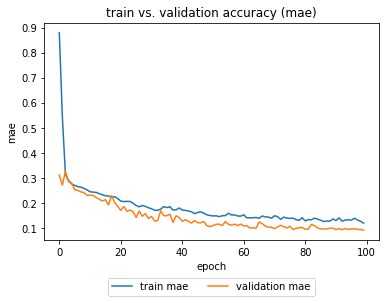

In [16]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

# Predict

In [17]:
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

(600, 20, 2) (181, 20, 2)
(600, 20, 2) (181, 20, 2)


In [18]:
# combine with the index
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)


In [19]:
# recover trend
data_final = dict()

for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))


train_pred: (600, 20, 2)
train_true: (600, 20, 2)
test_pred: (181, 20, 2)
test_true: (181, 20, 2)


In [20]:
for k in ['train_pred', 'train_true', 'test_pred', 'test_true']:
    print('maximum: {}'.format(k))
    print(data_final[k].max())

maximum: train_pred
215.64808219172795
maximum: train_true
222.70842177633597
maximum: test_pred
303.8765834188214
maximum: test_true
304.8853680078996


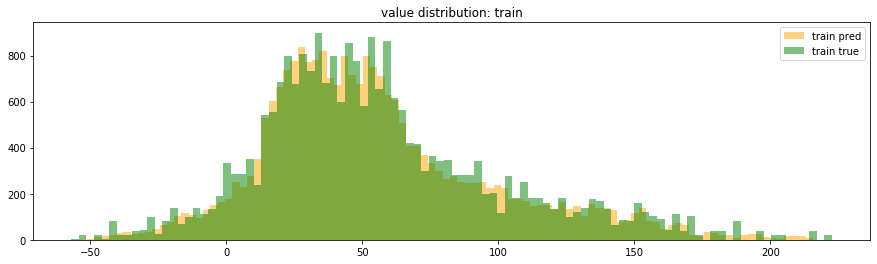

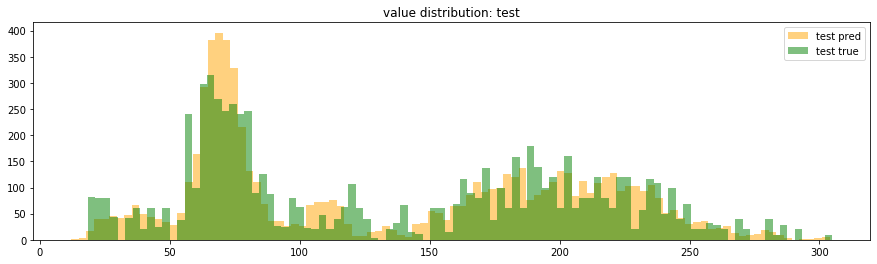

In [21]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

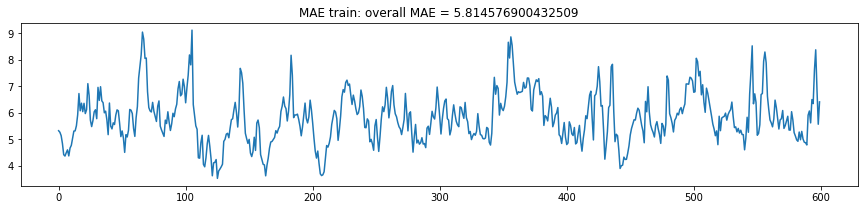

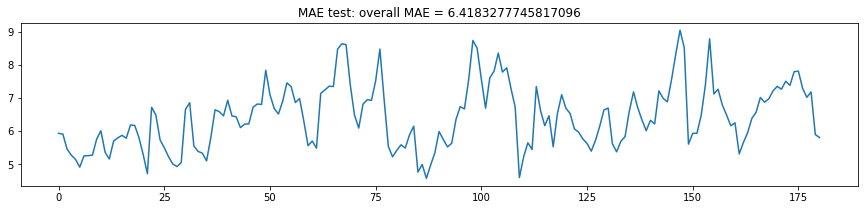

In [22]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show() 

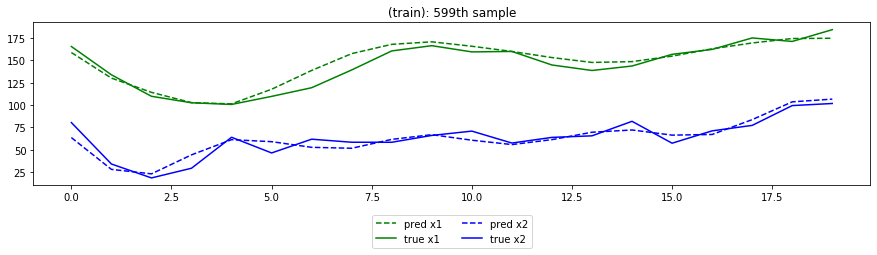

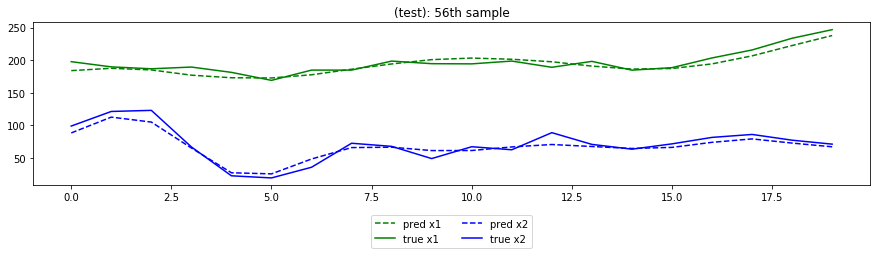

In [23]:
for lb in ['train', 'test']:
    ith_sample = random.choice(range(data_final[lb+'_pred'].shape[0]))

    plt.figure(figsize=(15,3))
    for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
        plt.plot(data_final[lb+'_pred'][ith_sample, :, i], linestyle='--', color=clr, label='pred '+x_lbl)
        plt.plot(data_final[lb+'_true'][ith_sample, :, i], linestyle='-', color=clr, label='true '+x_lbl)
    plt.title('({}): {}th sample'.format(lb, ith_sample))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()



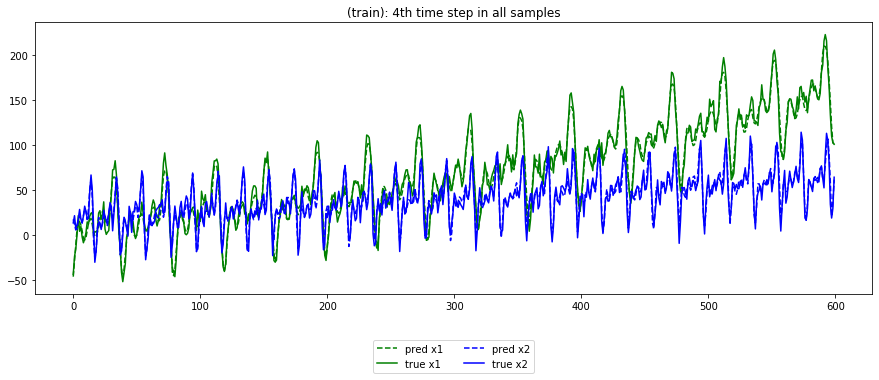

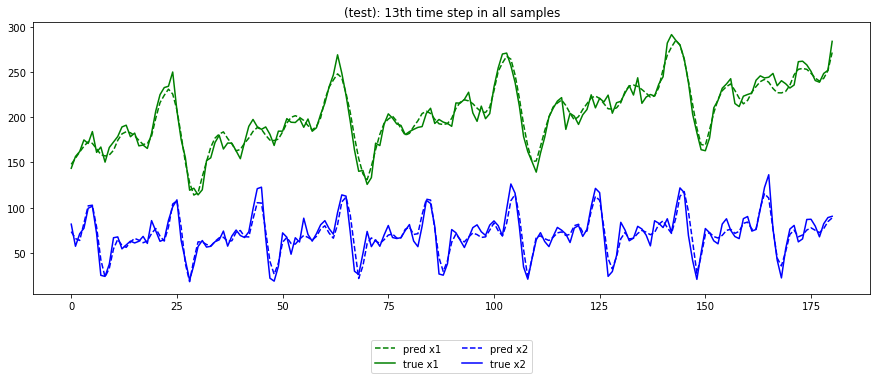

In [24]:
for lb in ['train', 'test']:
    ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
    plt.figure(figsize=(15, 5))
    for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
        plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
        plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
    plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()
